In [115]:
import bz2
import pandas as pd
import spacy
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from nltk import FreqDist
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [127]:
IO = "D:\\研2\\732A92 Text Mining\\\project\\recipes.xlsx"
sheet0 = pd.read_excel(io = IO, sheet_name = "zhengzong")  #241
sheet1 = pd.read_excel(io = IO, sheet_name = "xujia")     # 241
total = pd.concat([sheet0, sheet1], ignore_index=True)

total["instruction"] = [s.lower().replace("\n"," ") for s in total["instruction"]]   # 全小写, 去除\n
nlp = spacy.load('en_core_web_lg') # 用大(large)词典

In [176]:
total

,name,instruction,label
0,mapo tofu,add a small pinch of salt and sesame oil to mi...,0
1,Chinese Cured Pork Belly,"in a small pot, add rice cooking wine, soy sau...",0
2,Mung Bean Cake,pre-soak the yellow mung beans overnight. rins...,0
3,Skinny Chinese Pan-Fried Fish,cut the fish into large chunks around 3-4 cm t...,0
4,Glass Noodles Stir Fry with Shredded Cabbage,"in a large bowl, soak the glass noodles with h...",0
...,...,...,...
477,Jungguk-naengmyeon,1.soak the brisket in a bowl of water and set ...,1
478,Kkanpunggi,"prep the chicken combine the chicken, ginger,...",1
479,Kkanpung saeu,"clean the shrimp, drain, and pat dry with pape...",1
480,Rajogi,chicken flesh eating beomurinda put the cut ch...,1


In [128]:
# data1 = total.loc[total.label == 1]["instruction"]  # 所用虚假中餐的菜谱
data1 = total["instruction"]
nouns1 = []
verbs1 = []
nv1 = []
for recipe in data1:
    doc = nlp(recipe)
    lines = []
    for token in doc:
        p = token.pos_
        if token.is_stop == False and token.lemma_.isalpha() == True and len(token)>=2:
            if(p=="NOUN"):
                nouns1.append(token.lemma_)
            elif(p=="VERB"):
                verbs1.append(token.lemma_)
            lines.append(token.lemma_)
    nv1.append(lines)

In [184]:
## 作者主题模型
from gensim.corpora.dictionary import Dictionary
from gensim.models import AuthorTopicModel
dct = Dictionary(nv1)
corpus = [dct.doc2bow(text) for text in nv1]

author2doc = {"zhengzong": list(range(241)),
             "xujia":list(range(241, 482))}

model = AuthorTopicModel(corpus, num_topics=2, id2word=dct, author2doc=author2doc,
                 passes=100, random_state=0)

model.print_topics(num_topics=2, num_words=20)

[(0,
  '0.033*"add" + 0.023*"minute" + 0.022*"heat" + 0.022*"sauce" + 0.019*"oil" + 0.019*"cook" + 0.019*"stir" + 0.013*"chicken" + 0.012*"water" + 0.011*"bowl" + 0.010*"large" + 0.009*"medium" + 0.009*"fry" + 0.009*"serve" + 0.009*"rice" + 0.009*"pepper" + 0.008*"onion" + 0.008*"soy" + 0.008*"pan" + 0.008*"garlic"'),
 (1,
  '0.025*"add" + 0.022*"minute" + 0.019*"oil" + 0.019*"water" + 0.015*"fry" + 0.013*"heat" + 0.013*"sauce" + 0.011*"mix" + 0.010*"stir" + 0.010*"cook" + 0.009*"wok" + 0.009*"transfer" + 0.009*"serve" + 0.009*"bowl" + 0.008*"small" + 0.008*"pork" + 0.008*"salt" + 0.008*"tablespoon" + 0.007*"place" + 0.007*"cut"')]

In [185]:
model['xujia']
model.get_author_topics("zhengzong")

[(0, 0.9999367496221552)]

[(1, 0.9999533996789978)]

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = total[["label","instruction"]]

vectorizer = TfidfVectorizer(stop_words="english")
corpus = df["instruction"]
reviews = vectorizer.fit_transform(corpus)

In [74]:
reviews.shape

(482, 3136)

In [75]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init=20).fit(reviews)
# figsize(4, 3)
# pd.value_counts(kmeans.labels_).plot(kind='bar', rot=0)
sum(kmeans.labels_==total["label"])/total.shape[0]    ###### 21.6%

0.2157676348547718

In [76]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(reviews)
# pd.value_counts(kmedoids.labels_).plot(kind='bar', rot=0)
sum(kmedoids.labels_==total["label"])/total.shape[0] ##### 39.4%

0.3941908713692946

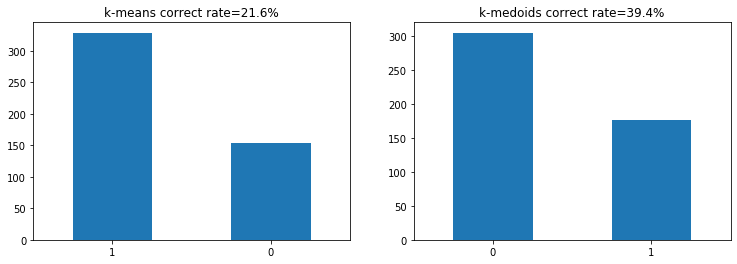

In [77]:
plt.figure(12)
figsize(12.5, 4)
plt.subplot(121)
pd.value_counts(kmeans.labels_).plot(kind='bar', rot=0)
plt.title('k-means correct rate=21.6%')
 
plt.subplot(122)
pd.value_counts(kmedoids.labels_).plot(kind='bar', rot=0)
plt.title('k-medoids correct rate=39.4%')

plt.show()

In [107]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

X = reviews
y = total["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state = 0)   # 361 vs 121
X_train.shape

(361, 3136)

In [108]:
mdl = svm.SVC(kernel='linear', random_state=0)  # rbf, sigmoid, polynomial
mdl = mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
y_pred1 = mdl.predict(X_train)
# print(sum(y_pred1==y_train)/X_train.shape[0])  #
print(sum(y_pred==y_test)/X_test.shape[0])  # 93.4%

0.9338842975206612


In [109]:
y_score = mdl.decision_function(X_test)

fpr,tpr,threshold = roc_curve(y_test, y_score) ###计算真正率和假正率

roc_auc = auc(fpr,tpr) ###计算auc的值
 
# plt.figure()
# plt.figure(figsize=(10,10))
# plt.plot(fpr, tpr, color="darkorange",
#          lw=3, label="ROC curve (Area = %0.2f)" % roc_auc) 
# plt.plot([0, 1], [0, 1], lw=3, linestyle='--')
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.xlabel('False Positive Rate', fontsize=20)
# plt.ylabel('True Positive Rate', fontsize=20)
# plt.title('ROC curve for Support Vector Classification', fontsize=20)
# plt.legend(loc='lower right', fontsize=20)
# plt.show()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[56  3]
 [ 5 57]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        59
           1       0.95      0.92      0.93        62

    accuracy                           0.93       121
   macro avg       0.93      0.93      0.93       121
weighted avg       0.93      0.93      0.93       121



In [110]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation='relu', hidden_layer_sizes=(100, 50), random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred2 = clf.predict(X_train)
# print(sum(y_pred2==y_train)/X_train.shape[0])  
print(sum(y_pred==y_test)/X_test.shape[0])  # 94.2%

0.9421487603305785


In [111]:
y_proba = clf.predict_proba(X_test)
# y_proba[:,1]
fpr1,tpr1,threshold1 = roc_curve(y_test, y_proba[:,1]) ###计算真正率和假正率

roc_auc = auc(fpr1,tpr1) ###计算auc的值
 
# plt.figure()
# plt.figure(figsize=(10,10))
# plt.plot(fpr1, tpr1, color="darkorange",
#          lw=3, label="ROC curve (Area = %0.2f)" % roc_auc) 
# plt.plot([0, 1], [0, 1], lw=3, linestyle='--')
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.xlabel('False Positive Rate', fontsize=20)
# plt.ylabel('True Positive Rate', fontsize=20)
# plt.title('ROC curve for Multi-layer Perceptron classifier', fontsize=20)
# plt.legend(loc='lower right', fontsize=20)
# plt.show()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[57  2]
 [ 5 57]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        59
           1       0.97      0.92      0.94        62

    accuracy                           0.94       121
   macro avg       0.94      0.94      0.94       121
weighted avg       0.94      0.94      0.94       121



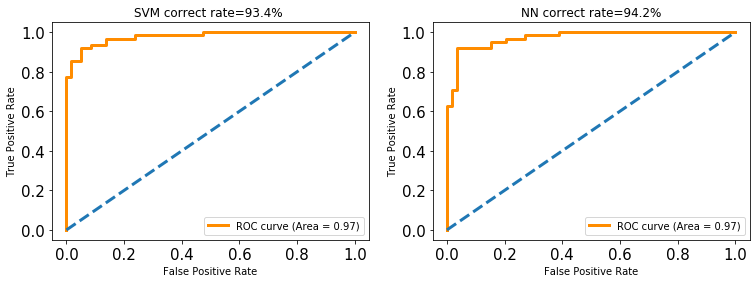

In [188]:
plt.figure(12)
figsize(12.5, 4)
plt.subplot(121)
plt.plot(fpr, tpr, color="darkorange",
         lw=3, label="ROC curve (Area = %0.2f)" % roc_auc) 
plt.plot([0, 1], [0, 1], lw=3, linestyle='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('SVM correct rate=93.4% ')
plt.legend(loc='lower right')
 
plt.subplot(122)
plt.plot(fpr1, tpr1, color="darkorange",
         lw=3, label="ROC curve (Area = %0.2f)" % roc_auc) 
plt.plot([0, 1], [0, 1], lw=3, linestyle='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('False Positive Rate', fontsize=10)
plt.ylabel('True Positive Rate', fontsize=10)
plt.title('NN correct rate=94.2%')
plt.legend(loc='lower right')

plt.show()